In [6]:
import pandas as pd
import os
import string
import numpy as np
import glob
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
from sklearn.preprocessing import MinMaxScaler
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [43]:
class Data(Dataset):
    def __init__(self, train_path, test_path):
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.seq_length = 7
        self.batch = 128

    def data_scaling(self):
        train_df = self.train_df
        test_df = self.test_df
        train_n, _ = train_df.shape
        test_n, _ = test_df.shape

        df_all = pd.concat([train_df, test_df], ignore_index=True)

        scaler_x = MinMaxScaler()
        scaler_x.fit(df_all.iloc[:, 2:7])
        df_all.iloc[:, 2:7] = scaler_x.transform(df_all.iloc[:, 2:7])

        scaler_y = MinMaxScaler()
        scaler_y.fit(df_all.iloc[:, [1]])
        df_all.iloc[:, [1]] = scaler_y.transform(df_all.iloc[:, [1]])

        imputer = SimpleImputer()
        train_imputer = imputer.fit(df_all.iloc[:train_n, 1:7])
        test_imputer = imputer.fit(df_all.iloc[:-test_n, 1:7])

        train_df = train_imputer.transform(df_all.iloc[:train_n, 1:7])
        test_df = test_imputer.transform(df_all.iloc[:-test_n, 1:7])

        return train_df, test_df, scaler_x, scaler_y

    def build_dataset(self, data, seq_length):
        X = []
        Y = []
        for i in range(0, len(data) - seq_length):
            _x = data[i:i+seq_length, :]
            _y = data[i+seq_length, [0]]
            X.append(_x)
            Y.append(_y)
        return np.array(X), np.array(Y)

    def get_dataset(self):
        train_df, test_df, scaler_x, scaler_y = self.data_scaling()
        train_X, train_y = self.build_dataset(train_df, self.seq_length)
        test_X, test_y = self.build_dataset(test_df, self.seq_length)
        return train_X, train_y, test_X, test_y, scaler_x, scaler_y


In [8]:
class BasicDataset(Dataset):
    def __init__(self, x, y):
        super(BasicDataset, self).__init__()
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        # 현재 인덱스에 해당하는 모든 유역의 데이터를 반환
        x_item = self.x[:, index, :, :]
        y_item = self.y[index]
        return x_item, y_item

    def __len__(self):
        return self.x.shape[1]  # num_samples

In [25]:
def get_data():
    # train, test dataset
    paldang_dataset = Data(train_path='./preprocessing/train/revised_pal17-21.csv', test_path='./preprocessing/test/revised_pal22.csv')
    p_train_X, p_train_y, p_test_X, p_test_y, p_scaler_x, p_scaler_y = paldang_dataset.get_dataset()

    gwang_dataset = Data(train_path='./preprocessing/train/revised_gwang17-21.csv', test_path='./preprocessing/test/revised_gwang22.csv')
    g_train_X, g_train_y, g_test_X, g_test_y, g_scaler_x, g_scaler_y = gwang_dataset.get_dataset()

    cheong_dataset = Data(train_path='./preprocessing/train/revised_cheong17-21.csv', test_path='./preprocessing/test/revised_cheong22.csv')
    c_train_X, c_train_y, c_test_X, c_test_y, c_scaler_x, c_scaler_y = cheong_dataset.get_dataset()

    haeng_dataset = Data(train_path='./preprocessing/train/revised_haeng17-21.csv', test_path='./preprocessing/test/revised_haeng22.csv')
    h_train_X, h_train_y, h_test_X, h_test_y, h_scaler_x, h_scaler_y = haeng_dataset.get_dataset()

    x_scaler = [p_scaler_x, g_scaler_x, c_scaler_x, h_scaler_x]
    y_scaler = [p_scaler_y, g_scaler_y, c_scaler_y, h_scaler_y]

    # change into float tensor type dataset
    p_train_X, g_train_X, c_train_X, h_train_X = torch.FloatTensor(p_train_X), torch.FloatTensor(g_train_X), torch.FloatTensor(c_train_X), torch.FloatTensor(h_train_X)
    p_train_y, g_train_y, c_train_y, h_train_y = torch.FloatTensor(p_train_y), torch.FloatTensor(g_train_y), torch.FloatTensor(c_train_y), torch.FloatTensor(h_train_y)
    
    p_test_X, g_test_X, c_test_X, h_test_X = torch.FloatTensor(p_test_X), torch.FloatTensor(g_test_X), torch.FloatTensor(c_test_X), torch.FloatTensor(h_test_X)
    p_test_y, g_test_y, c_test_y, h_test_y = torch.FloatTensor(p_test_y), torch.FloatTensor(g_test_y), torch.FloatTensor(c_test_y), torch.FloatTensor(h_train_y)

    # concatenate into one matrix
    X_train = torch.stack([p_train_X, g_train_X, c_train_X, h_train_X], dim=0)
    y_train = torch.stack([h_train_y.squeeze()], dim=1)

    X_test = torch.stack([p_test_X, g_test_X, c_test_X, h_test_X], dim=0)
    y_test = torch.stack([h_test_y.squeeze()], dim=1)

    train_dataset = BasicDataset(X_train, y_train)
    test_dataset = BasicDataset(X_test, y_test)

    return train_dataset, test_dataset, x_scaler, y_scaler

In [44]:
paldang_dataset = Data(train_path='./preprocessing/train/revised_pal17-21.csv', test_path='./preprocessing/test/revised_pal22.csv')
p_train_X, p_train_y, p_test_X, p_test_y, p_scaler_x, p_scaler_y = paldang_dataset.get_dataset()
train_dataset, test_dataset, x_scaler, y_scaler  = get_data()


(1826, 6)
(1826, 6)
(1819, 7, 6)
(1819, 1)
(1826, 6)
(1826, 6)
(1819, 7, 6)
(1819, 1)
(1826, 6)
(1826, 6)
(1819, 7, 6)
(1819, 1)
(1826, 6)
(1826, 6)
(1819, 7, 6)
(1819, 1)
(1826, 6)
(1826, 6)
(1819, 7, 6)
(1819, 1)


In [10]:
class RiverLevelPredictor(nn.Module):
    def __init__(self, num_basins, input_size, hidden_size, num_layers, output_size):
        super(RiverLevelPredictor, self).__init__()
        self.num_basins = num_basins
        self.linear = nn.Linear(2, 1)  # Combine stage and flux data for all basins
        self.lstm = nn.LSTM(input_size * num_basins, hidden_size, num_layers, batch_first=True)  # Add the linear output to the input
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def reset_hidden_state(self):
        device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
        return (torch.zeros(self.num_layers, self.hidden_size).to(device),
                torch.zeros(self.num_layers, self.hidden_size).to(device))

    def forward(self, x):
        # x shape: (num_basins, batch_size, seq_length, input_size)
        batch_size, num_basins, seq_length, input_size = x.size()

        # Extract stage and flux data (index 0 and 1)
        stage_and_flux = x[:, :, :, 0:2].reshape(batch_size, num_basins, seq_length, -1)

        # Apply linear layer to combine stage and flux data
        linear_out = self.linear(stage_and_flux)
        linear_out = linear_out.view(batch_size, num_basins, seq_length, -1)

        # Concatenate current stage, precipitation, temperature, humid, heat index and linear output
        current_stage = x[:, :, :, 0].unsqueeze(-1)
        precip = x[:, :, :, 2].unsqueeze(-1)
        temp = x[:, :, :, 3].unsqueeze(-1)
        humid = x[:, :, :, 4].unsqueeze(-1)
        heat = x[:, :, :, 5].unsqueeze(-1)

        lstm_input = torch.cat([current_stage, precip, temp, humid, heat, linear_out], dim=3)

        # LSTM layers
        lstm_input = lstm_input.permute(0, 2, 1, 3)  # shape: (batch_size, seq_length, num_basins, input_size)
        lstm_input = lstm_input.reshape(batch_size, seq_length, -1)  # shape: (batch_size, seq_length, num_basins * input_size)
        out, _ = self.lstm(lstm_input)
        
        # Fully connected layer
        out = self.fc(out[:, -1, :])

        return out

torch.Size([1819, 1])
Epoch [1/300], Loss: 0.003653
Epoch [11/300], Loss: 0.003894
Epoch [21/300], Loss: 0.003600
Epoch [31/300], Loss: 0.003372
Epoch [41/300], Loss: 0.002609
Epoch [51/300], Loss: 0.003096
Epoch [61/300], Loss: 0.003013
Epoch [71/300], Loss: 0.002955
Epoch [81/300], Loss: 0.002913
Epoch [91/300], Loss: 0.002883
Epoch [101/300], Loss: 0.002861
Epoch [111/300], Loss: 0.002840
Early stopping at epoch 116


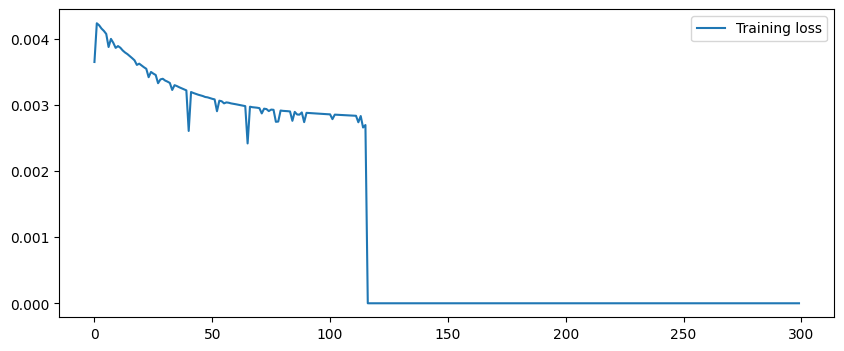

[array([0.00857071], dtype=float32), array([0.00404605], dtype=float32), array([-0.00470631], dtype=float32), array([0.01275103], dtype=float32), array([0.004826], dtype=float32), array([-0.00263264], dtype=float32), array([0.0023908], dtype=float32), array([-0.00281317], dtype=float32), array([-0.00453169], dtype=float32), array([0.01086023], dtype=float32), array([-0.00152055], dtype=float32), array([0.00061574], dtype=float32), array([0.01127718], dtype=float32), array([0.00984603], dtype=float32), array([0.00521812], dtype=float32), array([-0.00277306], dtype=float32), array([-0.00071671], dtype=float32), array([0.00147165], dtype=float32), array([0.0011516], dtype=float32), array([0.01041981], dtype=float32), array([0.01161306], dtype=float32), array([-0.00155309], dtype=float32), array([-0.0198507], dtype=float32), array([0.00640249], dtype=float32), array([0.00823962], dtype=float32), array([0.00150259], dtype=float32), array([0.01241384], dtype=float32), array([0.01027288], dty

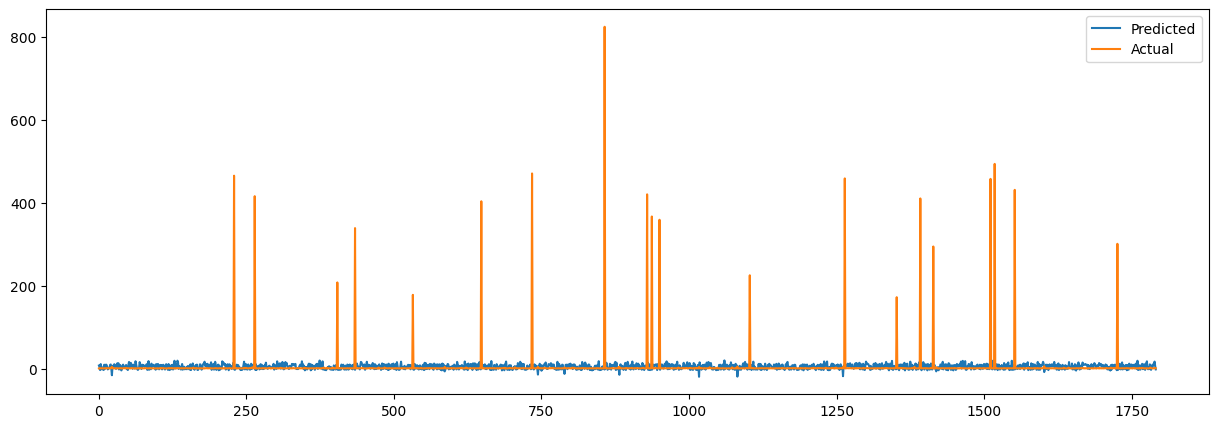

In [11]:
def train_model(device, model, data, num_epochs = None, lr = None, verbose = 10, patience = 50):
    # loss function, optimizer, number of epochs
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)

    # loading data from Dataloader
    loader = DataLoader(dataset = data, batch_size=128, shuffle = True, drop_last = True)
    
    # epoch마다 loss 저장
    train_hist = np.zeros(num_epochs)

    # Training loop
    best_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(loader):
            model.reset_hidden_state()
            
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(loader)
        train_hist[epoch] = avg_loss
        
        if epoch % verbose == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter += 1

        if counter == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    return model, train_hist

def test(model, test_loader, device, y_scaler):
    model.eval()
    mae_list = []
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:

            model.reset_hidden_state()

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_x)
            
            mae = nn.functional.l1_loss(outputs, batch_y, reduction='none').mean(1).cpu().numpy()
            mae_list.extend(mae.tolist())
            
            all_outputs.extend(outputs.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    print(all_outputs)
    mean_mae = np.mean(mae_list)
    print(f"Mean MAE: {mean_mae}")

    all_targets = y_scaler[3].inverse_transform(np.array(all_targets).reshape(-1, 1))
    all_outputs = y_scaler[3].inverse_transform(np.array(all_outputs).reshape(-1, 1))

    plt.figure(figsize=(15, 5))
    plt.plot(all_outputs, label='Predicted')
    plt.plot(all_targets, label='Actual')
    plt.legend()
    plt.show()

def main():
    # get data
    train_dataset, test_dataset, x_scaler, y_scaler = get_data()

    # select device
    device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

    # dimension
    input_size = 6  # 강수량, 유량, 수위, 온도, 습도, 열지수
    hidden_size = 64
    num_layers = 1
    output_size = 1  # 예측할 수위

    model = RiverLevelPredictor(4, input_size, hidden_size, num_layers, output_size).to(device)

    # hyperparameter
    n_epochs = 300
    learning_rate = 0.000001

    # train model
    train_hist = np.zeros(n_epochs)
    model, train_hist = train_model(device, model, train_dataset, num_epochs = n_epochs, lr = learning_rate, verbose = 10, patience = 50)

    # plot training loss
    plt.figure(figsize=(10,4))
    plt.plot(train_hist, label = 'Training loss')
    plt.legend()
    plt.show()

    # Testing loop
    test_loader = DataLoader(dataset = test_dataset, batch_size=128, shuffle = True, drop_last = True)
    test(model, test_loader, device, y_scaler)

if __name__ =='__main__':
    main()

In [6]:
# select device
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

# model 정의
# model = FullModel(input_size=len(dataset)).to(device)
# model = LSTMModel(input_size=3, hidden_size=100, output_size=1, seq_len = 12, layers = 4)
model = LSTMModel(input_size=3, hidden_size=50, output_size=1, seq_len = 12, layers = 4)

# hyperparameter
n_epochs = 100
learning_rate = 0.0008

# train model
train_hist = np.zeros(n_epochs)
# loss function, optimizer, number of epochs
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
nb_epochs = 100

# loading data from Dataloader
loader1 = DataLoader(dataset = p_train_dataset, batch_size=128, shuffle = True, drop_last = True)
loader2 = DataLoader(dataset = g_train_dataset, batch_size=128, shuffle = True, drop_last = True)
loader3 = DataLoader(dataset = c_train_dataset, batch_size=128, shuffle = True, drop_last = True)
loader4 = DataLoader(dataset = h_train_dataset, batch_size=128, shuffle = True, drop_last = True)

In [7]:
'''Paldang'''
verbose = 10
patience = 10
# epoch마다 loss 저장
train_hist = np.zeros(nb_epochs)
 
for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(p_train_dataset)
    iterator = tqdm.tqdm(loader1)
    for x, y in iterator:
        model.reset_hidden_state()

        outputs = model(x)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss/total_batch
  
        iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")                
            
    train_hist[epoch] = avg_cost        
    
    if epoch % verbose == 0:
        print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.8f}'.format(avg_cost))
        
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
        
        # loss가 커졌다면 early stop
        if train_hist[epoch-patience] < train_hist[epoch]:
            print('\n Early Stopping')
            break

# plot training loss
fig = plt.figure(figsize=(10,4))
plt.plot(train_hist, label = 'Training loss')
plt.legend()
plt.show()

with torch.no_grad(): 
    pred = []
    for pr in range(len(p_test_X)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(p_test_X[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = y_scaler[0].inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = y_scaler[0].inverse_transform(p_test_y)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.legend()
plt.show()

epoch:1 loss:0.00022999936481937766: 100%|██████████| 273/273 [00:05<00:00, 52.33it/s]


Epoch: 0000 train loss : 0.00001034


epoch:6 loss:4.309508949518204e-05:  77%|███████▋  | 210/273 [00:04<00:01, 49.67it/s] 


KeyboardInterrupt: 

epoch:1 loss:6.678211317279192e-10: 100%|██████████| 273/273 [00:05<00:00, 50.91it/s] 


Epoch: 0000 train loss : 0.00000007


epoch:11 loss:4.952727561402526e-09: 100%|██████████| 273/273 [00:04<00:00, 54.91it/s] 


Epoch: 0010 train loss : 0.00000000


epoch:21 loss:6.932352913935347e-09: 100%|██████████| 273/273 [00:04<00:00, 55.13it/s] 


Epoch: 0020 train loss : 0.00000000

 Early Stopping


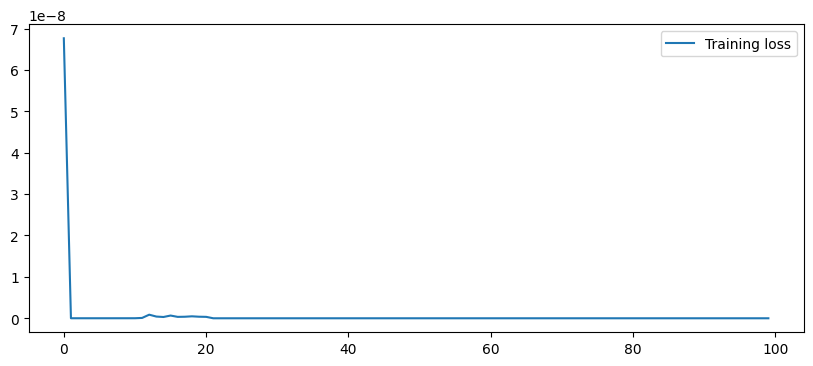

MAE SCORE :  0.7907657281749111


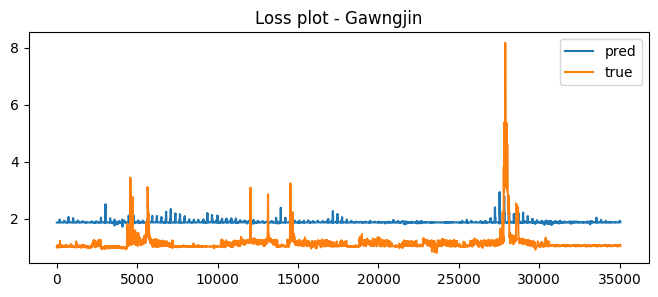

In [ ]:
'''Gawngjin'''
verbose = 10
patience = 10
# epoch마다 loss 저장
train_hist = np.zeros(nb_epochs)
 
for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(g_train_dataset)
    iterator = tqdm.tqdm(loader2)
    for x, y in iterator:
        model.reset_hidden_state()

        outputs = model(x)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss/total_batch
  
        iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")                
            
    train_hist[epoch] = avg_cost        
    
    if epoch % verbose == 0:
        print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.8f}'.format(avg_cost))
        
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
        
        # loss가 커졌다면 early stop
        if train_hist[epoch-patience] < train_hist[epoch]:
            print('\n Early Stopping')
            break

# plot training loss
fig = plt.figure(figsize=(10,4))
plt.plot(train_hist, label = 'Training loss')
plt.legend()
plt.show()

with torch.no_grad(): 
    pred = []
    for pr in range(len(g_test_X)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(g_test_X[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = y_scaler[1].inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = y_scaler[1].inverse_transform(g_test_y)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot - Gawngjin")
plt.legend()
plt.show()

epoch:1 loss:0.0006976252188906074: 100%|██████████| 273/273 [00:05<00:00, 51.94it/s] 


Epoch: 0000 train loss : 0.00001193


epoch:11 loss:0.00010070922144223005: 100%|██████████| 273/273 [00:05<00:00, 52.08it/s]


Epoch: 0010 train loss : 0.00000103


epoch:21 loss:0.00016829432570375502: 100%|██████████| 273/273 [00:05<00:00, 51.81it/s]


Epoch: 0020 train loss : 0.00000093


epoch:31 loss:0.00010086446854984388: 100%|██████████| 273/273 [00:05<00:00, 50.60it/s]


Epoch: 0030 train loss : 0.00000087


epoch:41 loss:0.00012502106255851686: 100%|██████████| 273/273 [00:05<00:00, 51.23it/s]


Epoch: 0040 train loss : 0.00000081


epoch:51 loss:9.001699072541669e-05: 100%|██████████| 273/273 [00:05<00:00, 50.92it/s] 


Epoch: 0050 train loss : 0.00000075


epoch:61 loss:0.00013176922220736742: 100%|██████████| 273/273 [00:05<00:00, 50.95it/s]


Epoch: 0060 train loss : 0.00000071


epoch:71 loss:7.771037053316832e-05: 100%|██████████| 273/273 [00:05<00:00, 50.39it/s] 


Epoch: 0070 train loss : 0.00000065


epoch:81 loss:9.307931759394705e-05: 100%|██████████| 273/273 [00:05<00:00, 50.85it/s] 


Epoch: 0080 train loss : 0.00000061


epoch:91 loss:0.00014036553329788148: 100%|██████████| 273/273 [00:05<00:00, 50.72it/s]


Epoch: 0090 train loss : 0.00000058


epoch:100 loss:0.00012667689588852227: 100%|██████████| 273/273 [00:05<00:00, 49.88it/s]


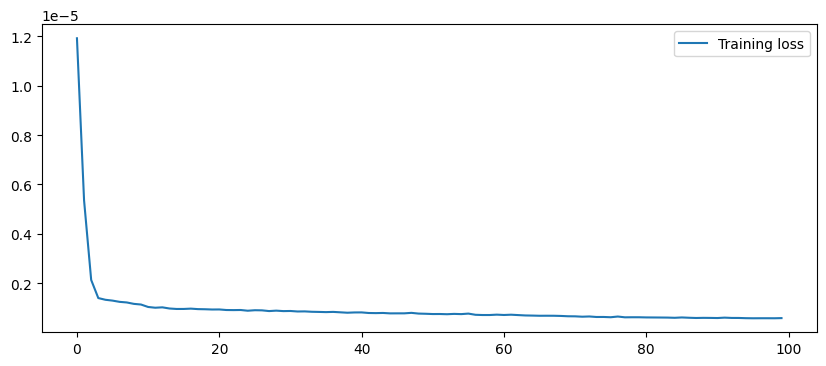

MAE SCORE :  0.04924319673790974


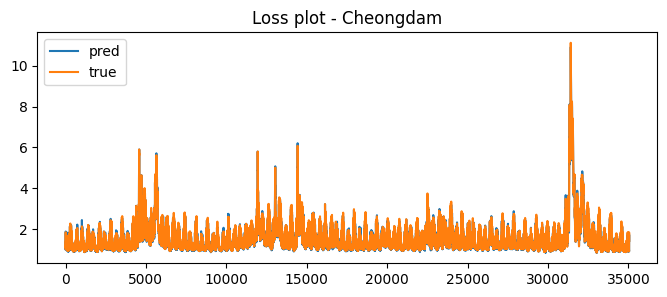

In [ ]:
'''Cheongdam'''
verbose = 10
patience = 10
# epoch마다 loss 저장
train_hist = np.zeros(nb_epochs)
 
for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(c_train_dataset)
    iterator = tqdm.tqdm(loader3)
    for x, y in iterator:
        model.reset_hidden_state()

        outputs = model(x)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss/total_batch
  
        iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")                
            
    train_hist[epoch] = avg_cost        
    
    if epoch % verbose == 0:
        print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.8f}'.format(avg_cost))
        
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
        
        # loss가 커졌다면 early stop
        if train_hist[epoch-patience] < train_hist[epoch]:
            print('\n Early Stopping')
            break

# plot training loss
fig = plt.figure(figsize=(10,4))
plt.plot(train_hist, label = 'Training loss')
plt.legend()
plt.show()

with torch.no_grad(): 
    pred = []
    for pr in range(len(c_test_X)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(c_test_X[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = y_scaler[2].inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = y_scaler[2].inverse_transform(c_test_y)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot - Cheongdam")
plt.legend()
plt.show()

epoch:1 loss:2.587721246527508e-05: 100%|██████████| 273/273 [00:05<00:00, 47.33it/s] 


Epoch: 0000 train loss : 0.00000032


epoch:11 loss:4.9632813897915184e-05: 100%|██████████| 273/273 [00:05<00:00, 51.00it/s]


Epoch: 0010 train loss : 0.00000030


epoch:21 loss:2.997701449203305e-05: 100%|██████████| 273/273 [00:05<00:00, 49.81it/s] 


Epoch: 0020 train loss : 0.00000029


epoch:31 loss:3.051700332434848e-05: 100%|██████████| 273/273 [00:05<00:00, 50.92it/s] 


Epoch: 0030 train loss : 0.00000028


epoch:41 loss:2.9912109312135726e-05: 100%|██████████| 273/273 [00:05<00:00, 50.43it/s]


Epoch: 0040 train loss : 0.00000027


epoch:51 loss:3.5838165786117315e-05: 100%|██████████| 273/273 [00:05<00:00, 50.88it/s]


Epoch: 0050 train loss : 0.00000025


epoch:61 loss:2.5906589144142345e-05: 100%|██████████| 273/273 [00:05<00:00, 50.93it/s]


Epoch: 0060 train loss : 0.00000024


epoch:71 loss:5.413596227299422e-05: 100%|██████████| 273/273 [00:05<00:00, 49.41it/s] 


Epoch: 0070 train loss : 0.00000023


epoch:81 loss:3.361490598763339e-05: 100%|██████████| 273/273 [00:05<00:00, 48.50it/s] 


Epoch: 0080 train loss : 0.00000022


epoch:91 loss:2.4236134777311236e-05: 100%|██████████| 273/273 [00:05<00:00, 48.78it/s]


Epoch: 0090 train loss : 0.00000021


epoch:100 loss:2.2890259060659446e-05: 100%|██████████| 273/273 [00:05<00:00, 50.51it/s]


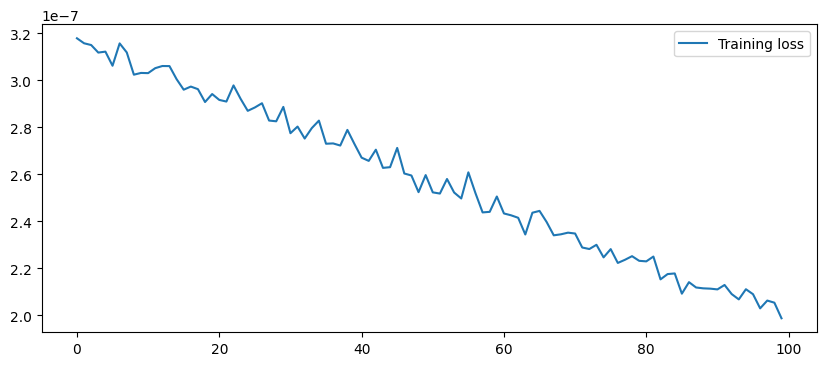

MAE SCORE :  0.029014241324545727


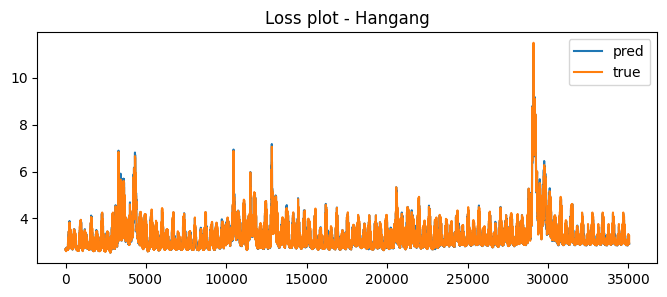

In [ ]:
'''Hangang'''
verbose = 10
patience = 10
# epoch마다 loss 저장
train_hist = np.zeros(nb_epochs)
 
for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(h_train_dataset)
    iterator = tqdm.tqdm(loader4)
    for x, y in iterator:
        model.reset_hidden_state()

        outputs = model(x)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_cost += loss/total_batch
  
        iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")                
            
    train_hist[epoch] = avg_cost        
    
    if epoch % verbose == 0:
        print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.8f}'.format(avg_cost))
        
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
        
        # loss가 커졌다면 early stop
        if train_hist[epoch-patience] < train_hist[epoch]:
            print('\n Early Stopping')
            break

# plot training loss
fig = plt.figure(figsize=(10,4))
plt.plot(train_hist, label = 'Training loss')
plt.legend()
plt.show()

with torch.no_grad(): 
    pred = []
    for pr in range(len(h_test_X)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(h_test_X[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = y_scaler[3].inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = y_scaler[3].inverse_transform(h_test_y)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot - Hangang")
plt.legend()
plt.show()